# Getting Started Keras RNNs

Text data is everywhere and there is plenty of it Therefore it is of no surprise that the analysis of text data has gained popularity in Machine learning. A few applications of machine learning on text data include:

1. Machine translation
2. Sentiment classification
3. Multi-class classification 
4. Text generations (e.g question and answer systems)
5. Entity extraction

Recurrent neural networks (RNNs) have been the popular algorithm to solve these problems.

In this tutorial, we therefore demonstrate how to use an RNN to classify text data. 


## The data set

The data set that we will be looking at is the real or not real twitter data downloaded from [kaggle.](https://www.kaggle.com/c/nlp-getting-started)

This is a binary classification task and we use glove emmeddings

In [0]:
#import all dependencies
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random
from google.colab import drive

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Input
from keras.layers import Bidirectional, GlobalMaxPool1D, LSTM, GRU, SimpleRNN
from keras.initializers import Constant
from keras.models import Model
import matplotlib.pyplot as plt
import os
import sys

In [3]:
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train = pd.read_csv("/content/drive/My Drive/twitterfakenews/train.csv", engine="python", encoding = "latin1", index_col = 'id')
test = pd.read_csv("/content/drive/My Drive/twitterfakenews/test.csv", engine="python", encoding = "latin1")

## High level EDA

In [51]:
train.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [52]:
train.dtypes

keyword     object
location    object
text        object
target       int64
dtype: object

The target is an integer, it should be bool 1 or 0. Let us do more EDA

In [53]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 1 to 10873
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   keyword   7552 non-null   object
 1   location  5080 non-null   object
 2   text      7613 non-null   object
 3   target    7613 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 297.4+ KB


In [0]:
import seaborn as sns

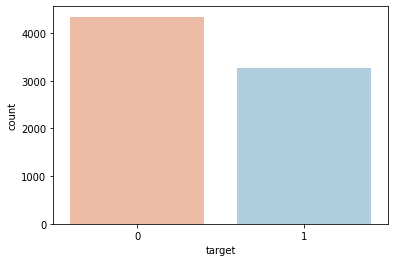

In [55]:
sns.countplot(x = 'target', data = train, palette = 'RdBu') #looks fine

## Data prep

In [0]:
train.drop(["keyword", "location"], axis = 1, inplace = True)
test.drop(["keyword", "location"], axis = 1, inplace = True)

In [0]:
#clean tweet
def clean_tweet(tweet):
  tweet = BeautifulSoup(tweet, "lxml").get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet) #remove mentions
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
  tweet = re.sub(r"[^a-zA-Z.!?']", ' ', tweet)
  tweet = re.sub(r" +", ' ', tweet)
  return tweet

In [0]:
X_train = [clean_tweet(tweet) for tweet in train.text]
#convert training lables to categorical
data_lables = to_categorical(train.target)
X_test = [clean_tweet(tweet) for tweet in test.text]

In [110]:
#preview
X_train[0:5]

['Our Deeds are the Reason of this earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 ' people receive wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school ']

## Tokenisation

In [0]:
#creates a tokenizer from training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

## Text to sequence

In [0]:
#text to sequence
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

## Pad sequence

In [0]:
#Make each sentence have equal length
#maximum length of a tweet
sentence_len = 280
#apply
X_train = pad_sequences(X_train, maxlen = sentence_len)
X_test = pad_sequences(X_test, maxlen = sentence_len)

In [91]:
X_train.shape

(7613, 280)

## GloVE word vectors
You can download this language model here:

https://nlp.stanford.edu/projects/glove/

Filter glove to only use the words present in the vocabulary list 

In [0]:
#get glove embeddings, this takes a while to run
glove_dic = {}
f = open('/content/drive/My Drive/twitterfakenews/glove.twitter.27B/glove.twitter.27B.200d.txt','r',  encoding = 'utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_dic[word] = coefs
f.close()

print('Found %s word vectors.' % len())

In [119]:
#get total words in vocabulary
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14956 unique tokens.


In [0]:
#emedding dimension
wordvec_dim = 200

In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, wordvec_dim))
for word, i in word_index.items():
    embedding_vector = glove_dic.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Model building

In [0]:
inp = Input(shape=(sentence_len,))
x = Embedding(len(word_index) + 1, wordvec_dim, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [157]:
# Train the model, iterating on the data in batches of 32 samples
history = model.fit(X_train,  data_labels, epochs=5, batch_size=32, validation_split = .2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6090 samples, validate on 1523 samples
Epoch 1/5
6090/6090 [==============================] - 99s 16ms/step - loss: 0.4866 - accuracy: 0.7754 - val_loss: 0.4123 - val_accuracy: 0.8148
Epoch 2/5
6090/6090 [==============================] - 97s 16ms/step - loss: 0.3659 - accuracy: 0.8468 - val_loss: 0.4186 - val_accuracy: 0.8122
Epoch 3/5
6090/6090 [==============================] - 97s 16ms/step - loss: 0.2796 - accuracy: 0.8864 - val_loss: 0.4477 - val_accuracy: 0.8017
Epoch 4/5
6090/6090 [==============================] - 95s 16ms/step - loss: 0.2046 - accuracy: 0.9210 - val_loss: 0.5325 - val_accuracy: 0.7781
Epoch 5/5
6090/6090 [==============================] - 95s 16ms/step - loss: 0.1378 - accuracy: 0.9502 - val_loss: 0.5899 - val_accuracy: 0.7866


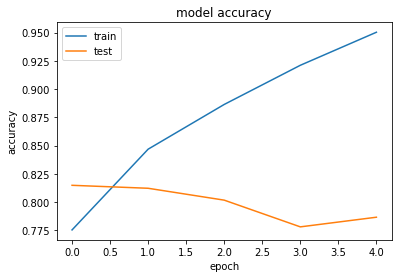

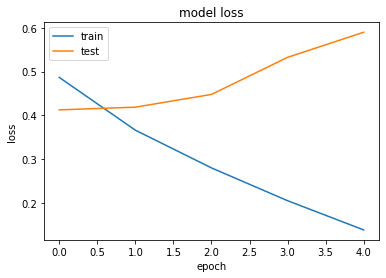

In [160]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Make predictions


In [0]:
pred_probabilities = model.predict(X_test)

In [150]:
pred_probabilities

array([[0.952118  ],
       [0.9728527 ],
       [0.9991933 ],
       ...,
       [0.99975735],
       [0.9869581 ],
       [0.9923557 ]], dtype=float32)

In [0]:
y_pred = np.matrix( pred_probabilities)
pred = pd.DataFrame(y_pred)
ids = pd.DataFrame(test[['id']])
df = pd.concat([ids, pred], axis = 1)
df.columns = ['id', 'target']
df.set_index('id', inplace=True)

In [0]:
df['target'] = df['target'].apply(lambda x: 0 if x < .5 else 1)

In [153]:
df.head()

,target
id,
0,1
2,1
3,1
9,1
11,1


In [0]:
#save
df.to_csv("/content/drive/My Drive/twitterfakenews/mysubmission.csv")

[link text](https://)I got a score on kaggle of 0.77536 (without, cleaning the tweets), much better than the zero, without embedding layer

In [0]:
#submit to kaggle
!kaggle competitions submit -c nlp-getting-started -f submission_three.csv -m "2ndsubmission"